<img style="float: left; margin: 30px 15px 15px 15px;" src="https://oci02.img.iteso.mx/Identidades-De-Instancia/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg" width="500" height="250" /> 
    
    
# <font color='navy'> Backtest

<font color='black'>

- Luis Fernando Márquez Bañuelos

In [1]:
import ta
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme()

In [2]:
from dataclasses import dataclass

@dataclass
class Position:
    """ A cool representation of a position
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    time: str

In [3]:
def get_portfolio_value(cash: float, long_ops: list[Position], short_ops: list[Position], current_price: float, n_shares: int) -> float:
    val = cash

    # Add long positions value
    val += len(long_ops) * current_price * n_shares

    return val

In [4]:
data = pd.read_csv('aapl_5m_train.csv').dropna()

## <font color='cornflowerblue'> Optimization

In [5]:
def objective(trial, data) -> float:

    data = data.copy()

    # Hyperparameters to optimize
    rsi_window = trial.suggest_int('rsi_window', 8, 80)
    rsi_lower = trial.suggest_int('rsi_lower', 5, 35)
    #rsi_upper = trial.suggest_int('rsi_upper', 65, 95)
    stop_loss = trial.suggest_float('stop_loss', 0.01, 0.15)
    take_profit = trial.suggest_float('take_profit', 0.01, 0.15)
    n_shares = trial.suggest_int('n_shares', 5, 500)

    # Indicators
    rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data['rsi'] = rsi_indicator.rsi()

    # Signals
    data['buy_signal'] = data.rsi < rsi_lower
    #data['sell_signal'] = data.rsi > rsi_upper

    data = data.dropna()

    # Initial values
    capital: float = 1_000_000
    portfolio_value = [capital]
    active_long_positions: list[Position] = []

    # Commissions and rates
    COM: float = 0.125 / 100
    BORROW_RATE: float = 0.25 / 100

    # Strategy parameters
    STOP_LOSS: float = stop_loss
    TAKE_PROFIT: float = take_profit
    N_SHARES: int = n_shares

    for i, row in data.iterrows():
        # -- LONG -- #
        # Check active orders
        for position in active_long_positions.copy():
            # Stop loss or take profit check
            if row.Close > position.tp or row.Close < position.sl:
                # Add profits / losses to capital
                capital += row.Close * position.n_shares * (1 - COM)
                # Remove position from active position
                active_long_positions.remove(position)

        # Check Signal
        if row.buy_signal:
            cost = row.Close * N_SHARES * (1 + COM)

            # Do we have enough cash?
            if capital > cost:
                # Discount cash
                capital -= cost
                # Add position to portfolio
                pos = Position(ticker='AAPL', n_shares = N_SHARES, price = row.Close,
                            sl = row.Close * (1 - STOP_LOSS), tp = row.Close*(1 + TAKE_PROFIT),
                            time = row.Datetime)
                active_long_positions.append(pos)

        portfolio_value.append(get_portfolio_value(capital, active_long_positions, [], row.Close, N_SHARES))

    # At the end of the backtesting, we sholud close all active positions
    capital += row.Close * len(active_long_positions) * N_SHARES * (1 - COM)
    active_long_positions = []

    df = pd.DataFrame()
    df['Value'] = portfolio_value
    df['rets'] = df.Value.pct_change()
    df.dropna(inplace=True)

    mean = df.rets.mean()
    std = df.rets.std()
    down_risk = df.rets[df.rets < 0].fillna(0).std()

    anual_rets = mean * (60 / 5) * 6.5 * 252
    anual_std = std * np.sqrt((60 / 5) * 6.5 * 252)
    anual_down_risk = down_risk * np.sqrt((60 / 5) * 6.5 * 252)

    return anual_rets / anual_down_risk if anual_std != 0 else 0

In [6]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, data), n_trials=5, n_jobs=-1)

[I 2025-09-20 12:01:00,340] A new study created in memory with name: no-name-3c3926e2-dd31-46de-bc42-5c1093ebdb67
[I 2025-09-20 12:01:03,872] Trial 0 finished with value: 0.0 and parameters: {'rsi_window': 59, 'rsi_lower': 18, 'stop_loss': 0.04170527748512848, 'take_profit': 0.0949288739377467, 'n_shares': 447}. Best is trial 0 with value: 0.0.
[I 2025-09-20 12:01:04,022] Trial 1 finished with value: -0.12805523640983235 and parameters: {'rsi_window': 41, 'rsi_lower': 25, 'stop_loss': 0.06001411801723347, 'take_profit': 0.05769166444608057, 'n_shares': 142}. Best is trial 0 with value: 0.0.
[I 2025-09-20 12:01:04,060] Trial 2 finished with value: 0.1866004543832754 and parameters: {'rsi_window': 30, 'rsi_lower': 16, 'stop_loss': 0.12353287869080626, 'take_profit': 0.054061936132720936, 'n_shares': 11}. Best is trial 2 with value: 0.1866004543832754.
[I 2025-09-20 12:01:04,067] Trial 3 finished with value: 0.7133674888833785 and parameters: {'rsi_window': 56, 'rsi_lower': 26, 'stop_loss

In [7]:
study.best_params

{'rsi_window': 56,
 'rsi_lower': 26,
 'stop_loss': 0.14530071918322116,
 'take_profit': 0.14833559287512751,
 'n_shares': 176}

In [8]:
study.best_value

0.7133674888833785

## <font color='cornflowerblue'> Optimized Parameters

In [9]:
# Windows
window = study.best_params['rsi_window']
lower = study.best_params['rsi_lower']
#upper = study.best_params['rsi_upper']

# Commissions and rates
COM = 0.125 / 100
BORROW_RATE = 0.25 / 100
INITIAL_MARGIN = 0.5
MAINTENANCE_MARGIN = 0.25

# Strategy parameters
STOP_LOSS: float = study.best_params['stop_loss']
TAKE_PROFIT: float = study.best_params['take_profit']
N_SHARES: int = study.best_params['n_shares']

capital: float = 1_000_000
active_long_positions: list[Position] = []
portfolio_value = [capital]

In [10]:
# Data
data = pd.read_csv('aapl_5m_train.csv').dropna()

# Indicators
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=window)
data['rsi'] = rsi_indicator.rsi()

# Signals
data['buy_signal'] = data['rsi'] < lower
#data['sell_signal'] = data['rsi'] > upper

In [11]:
for i, row in data.iterrows():
    # -- LONG -- #
    # Check active orders
    for position in active_long_positions.copy():
        # Stop loss or take profit check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            capital += row.Close * position.n_shares * (1 - COM)
            # Remove position from active position
            active_long_positions.remove(position)

    # Check Signal
    if row.buy_signal:
        cost = row.Close * N_SHARES * (1 + COM)

        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares = N_SHARES, price = row.Close,
                           sl = row.Close * (1 - STOP_LOSS), tp = row.Close*(1 + TAKE_PROFIT),
                           time = row.Datetime)
            active_long_positions.append(pos)

    portfolio_value.append(get_portfolio_value(capital, active_long_positions, [], row.Close, N_SHARES))

# At the end of the backtesting, we sholud close all active positions
capital += row.Close * len(active_long_positions) * N_SHARES * (1 - COM)
active_long_positions = []

In [12]:
capital

1066369.33703884

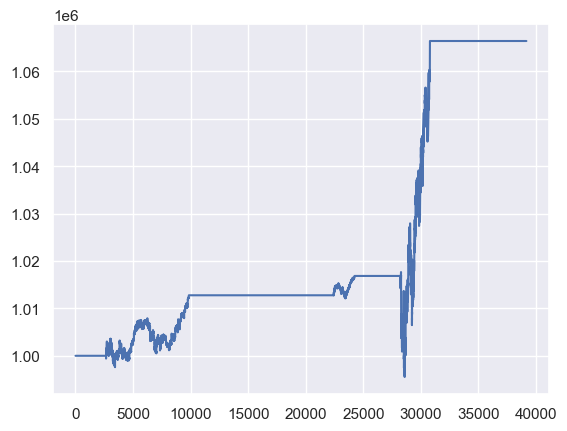

In [13]:
plt.plot(portfolio_value);

In [14]:
df = pd.DataFrame()
df['Value'] = portfolio_value
df['rets'] = df.Value.pct_change()
df.dropna(inplace=True)

mean = df.rets.mean()
std = df.rets.std()

anual_rets = mean * (60 / 5) * 6.5 * 252
anual_std = std * np.sqrt((60 / 5) * 6.5 * 252)

anual_rets / anual_std

1.1800845131312077